# Compare TNS Transients to DESI Targets

Access a list of transients reported to the [Transient Name Server](https://wis-tns.weizmann.ac.il/) (TNS) between Jan. 1 2020 and Mar. 25, 2020. See if any of our fibers happened to be pointing at publicly reported transients.

Note: TNS is the primary IAU database for reporting public transients. It includes alerts from all major optical transient facilities and surveys such as ZTF, PTF, ASASSN, etc.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import healpy as hp

from desispec.io import read_spectra
from desispec.spectra import Spectra
from desispec.interpolation import resample_flux
from desitarget.cmx.cmx_targetmask import cmx_mask
from desimodel.focalplane.geometry import radec2xy

from astropy.table import vstack, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.io import ascii
from glob import glob

mpl.rc('font', size=14)

## Load TNS Data

All-sky from TNS were manually downloaded into several comma-separated variable (CSV) files.

This loop reads through all the files, removes duplicate entries, and sorts the output table by discovery date.

In [3]:
tnsdata = None
tnsfiles = glob('data-2020-q1/tns_search*.csv')
for tnsfile in tnsfiles:
    if tnsdata is None:
        tnsdata = ascii.read(tnsfile)
    else:
        tnsdata = vstack([tnsdata, ascii.read(tnsfile)])
tnsdata = unique(tnsdata, keys='ID')
tnsdata.sort('Discovery Date (UT)')

In [4]:
tnsdata

ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s
int64,str10,str12,str12,str17,float64,str36,float64,str50,str45,str17,str45,str29,str114,str32,int64,int64,int64,float64,str12,str23,str18,int64,str56
58454,AT 2020hxd,10:29:00.718,+03:01:11.50,--,--,--,--,YSE,Pan-STARRS1,--,Pan-STARRS1,PS20cmn,PS1 - GPC1,--,1,1,--,21.13,g-Sloan,2020-01-01 14:42:43.200,YSE_Bot1,--,--
58975,AT 2020iqz,12:17:26.982,+13:23:18.66,--,--,--,--,YSE,Pan-STARRS1,--,Pan-STARRS1,PS20cjo,PS1 - GPC1,--,1,1,--,21.3,g-Sloan,2020-01-01 15:43:12.000,YSE_Bot1,--,--
58863,AT 2020imr,12:19:00.970,+10:20:11.63,--,--,--,--,YSE,Pan-STARRS1,--,Pan-STARRS1,PS20cjy,PS1 - GPC1,--,1,1,--,21.21,g-Sloan,2020-01-01 15:43:12.000,YSE_Bot1,--,--
59626,AT 2020jpr,12:20:24.891,+08:36:21.60,--,--,--,--,YSE,Pan-STARRS1,--,Pan-STARRS1,PS20cyl,PS1 - GPC1,--,1,1,--,19.9,i-Sloan,2020-01-01 15:46:04.800,YSE_Bot1,--,--
60318,AT 2020kpu,12:19:04.796,+13:12:44.37,--,--,--,--,YSE,Pan-STARRS1,--,Pan-STARRS1,PS20dhm,PS1 - GPC1,--,1,1,--,21.6,i-Sloan,2020-01-01 15:46:04.800,YSE_Bot1,--,--
54499,AT 2020czq,12:31:25.335,-20:07:32.22,--,--,--,--,ZTF,ZTF,--,ZTF,ZTF19aaskpkz,P48 - ZTF-Cam,--,1,1,--,19.72,g-ZTF,2020-01-03 12:32:17.000,ZTF_AMPEL_COMPLETE,--,--
56998,AT 2020fvm,14:12:45.972,+34:44:16.24,--,--,--,--,"ZTF, Pan-STARRS1","ZTF, Pan-STARRS1",--,Pan-STARRS1; ZTF,ZTF20aadzbcf,"P48 - ZTF-Cam, PS1 - GPC1",--,1,1,--,20.67,r-ZTF,2020-01-05 13:20:38.400,ZTF_Bot1,--,--
54656,AT 2020dfr,04:22:08.400,-68:49:40.10,--,--,OGLE-GAL-LMC546.32-900.406-2301.205,--,OGLE,OGLE,--,OGLE,--,OGLE-1.3m - OGLEIV-Cam,--,1,1,--,18.681,I-Cousins,2020-01-07 02:19:07.000,Gromadzki,--,--
54533,AT 2020day,12:41:58.200,+60:38:46.46,--,--,SDSS J124158.16+603846.4,--,ZUDS,ZTF,--,ZUDS,ZUDS20drtvq,P48 - ZTF-Cam,--,1,1,--,20.5,g-ZTF,2020-01-07 12:00:00.000,Goldstein,--,--


## Plot TNS Coordinates

Make a sky plot of the positions of TNS alerts reported between January and March. Use the `healpy` library to make the plot in a nice Mollweide projection of the sky.

In [5]:
# Convert TNS right ascension and declination to angles we can plot.
# Note: the RA/DEC epoch is not reported anywhere on the TNS website,
# so we're going just assume all coordinates are in ICRS.
tnscoords = SkyCoord(tnsdata['RA'], tnsdata['DEC'], unit=('hourangle', 'degree'), frame='icrs')

### Plot Coordinates in Mollweide Projection

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 45 deg 0.00'.
  warnings.warn(


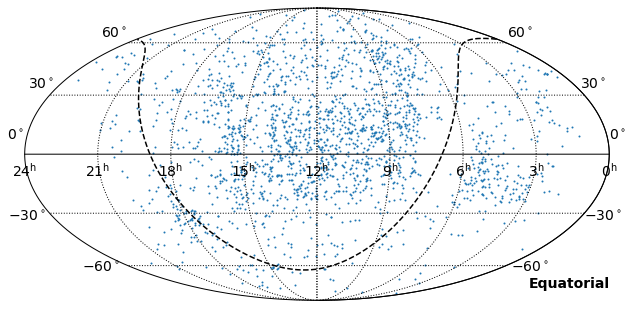

In [6]:
nside = 4
npix = hp.nside2npix(nside)
bkg = np.zeros(npix)
hp.mollview(bkg, cmap='binary', min=0, max=1, cbar=False, flip='astro', rot=180, coord='C', title='')
hp.graticule(dpar=30, dmer=45)

# Plot the TNS alert positions as little filled dots.
hp.projscatter(tnscoords.ra, tnscoords.dec, lonlat=True, marker='o', s=1);

# Plot the Galactic Plane for reference.
l = np.linspace(0,360,360)
b = np.zeros_like(l)
hp.projplot(l, b, lonlat=True, coord='GC', ls='--', color='k')

# Cause it looks cool, add some nice labels to the plot.
ax = plt.gca()

# Label latitude lines.
ax.text( 2.00,  0.10, r'$0^\circ$', horizontalalignment='left')
ax.text( 1.80,  0.45, r'$30^\circ$', horizontalalignment='left')
ax.text( 1.30,  0.80, r'$60^\circ$', horizontalalignment='left')
ax.text( 1.83, -0.45, r'$-30^\circ$', horizontalalignment='left')
ax.text( 1.33, -0.80, r'$-60^\circ$', horizontalalignment='left')
ax.text(-2.00,  0.10, r'$0^\circ$', horizontalalignment='right')
ax.text(-1.80,  0.45, r'$30^\circ$', horizontalalignment='right')
ax.text(-1.30,  0.80, r'$60^\circ$', horizontalalignment='right')
ax.text(-1.85, -0.45, r'$-30^\circ$', horizontalalignment='right')
ax.text(-1.35, -0.80, r'$-60^\circ$', horizontalalignment='right')

# Label longitude lines.
ax.text( 2.0, -0.15, r'0$^\mathrm{h}$', horizontalalignment='center')
ax.text( 1.5, -0.15, r'3$^\mathrm{h}$', horizontalalignment='center')
ax.text( 1.0, -0.15, r'6$^\mathrm{h}$', horizontalalignment='center')
ax.text( 0.5, -0.15, r'9$^\mathrm{h}$', horizontalalignment='center')
ax.text( 0.0, -0.15, r'12$^\mathrm{h}$', horizontalalignment='center')
ax.text(-0.5, -0.15, r'15$^\mathrm{h}$', horizontalalignment='center')
ax.text(-1.0, -0.15, r'18$^\mathrm{h}$', horizontalalignment='center')
ax.text(-1.5, -0.15, r'21$^\mathrm{h}$', horizontalalignment='center')
ax.text(-2.0, -0.15, r'24$^\mathrm{h}$', horizontalalignment='center');

## Grab DESI Targets from SV0

We're going to extract data from several DESI tiles observed on March 14 and 15 2020. There are around 3000 Bright Galaxy Survey (BGS) targets in each tile.

In [7]:
# Technical detail: this code will help us pick fibers allocated to BGS targets down below...
cmx_bgs_bits = '|'.join([_ for _ in cmx_mask.names() if 'BGS' in _])

### List of BGS Tiles from DESI Survey Validation

From March 14, 2020:
- Tile 66000
- Tile 66014
- Tile 66019

From March 15, 2020:
- Tile 66003

#### Plotting Function

This function will plot the xy positions of all DESI fibers in the focal plane for a given tile.

Moreover, if you give it the TNS data table, it will plot the location of transients within the field of view of the focal plane. If a transient is in the field of view it will appear as a red star.

In [8]:
def compare_tile_to_tns(tileid, yyyymmdd, tnsdata):
    """Function that extracts DESI target locations and compares them to the TNS positions.
    
    Parameters
    ----------
    tileid : int
        ID number of the tile.
    yyyymmdd : int
        Date of the observation, in the format YYYYMMDD.
    tnsdata : astropy.Table
        Table of TNS transients.
    """
    
    # Access all coadd files for the given tile and its date.
    coadds = sorted(glob('/global/project/projectdirs/desi/spectro/redux/daily/tiles/{}/{}/coadd*.fits'.format(tileid, yyyymmdd)))
    if len(coadds) == 0:
        raise ValueError('Problem with input tile ID {} or date {}'.format(tileid, yyyymmdd))
        
    # Grab fibermaps from all the coadd files. This contains information about the fibers' targeting values.
    spec_fibermaps = None
    for coadd in coadds:
        spectra = read_spectra(coadd)
        if spec_fibermaps is None:
            spec_fibermaps = spectra.fibermap
        else:
            spec_fibermaps = vstack([spec_fibermaps, spectra.fibermap])
            
    # Grab science fibers (not sky fibers) allocated to BGS targets:
    isTGT = spec_fibermaps['OBJTYPE'] == 'TGT'
    isBGS = spec_fibermaps['CMX_TARGET'] & cmx_mask.mask(cmx_bgs_bits) != 0
    selection = isTGT & isBGS
    
    # Access fiber RA, DEC, and xy position in the DESI focal plane.
    fiber_ra  = spec_fibermaps[selection]['TARGET_RA']
    fiber_dec = spec_fibermaps[selection]['TARGET_DEC']
    fiber_x   = spec_fibermaps[selection]['FIBERASSIGN_X']
    fiber_y   = spec_fibermaps[selection]['FIBERASSIGN_Y']
    
    # Access TNS RA and DEC. Convert them to DESI x and y.
    # Comment: telescope RA and Dec are not propagated to the coadds, so we'll cheat
    # and compute the barycenter of the fibers.
    telra  = np.asarray([np.average(fiber_ra),])
    teldec = np.asarray([np.average(fiber_dec,)])
    telcoord = SkyCoord(telra, teldec, unit=('degree', 'degree'), frame='icrs')

    # Compute TNS coordinates and see if any are within the telescope FOV.
    tnscoords = SkyCoord(tnsdata['RA'], tnsdata['DEC'], unit=('hourangle', 'degree'), frame='icrs')
    idx, sep2d, dist3d = match_coordinates_sky(tnscoords, telcoord)
    isInFOV = sep2d < 1.6*u.degree
    tns_x, tns_y = radec2xy(telra, teldec, tnscoords.ra[isInFOV], tnscoords.dec[isInFOV])
    
    # Plot the fiber positions (blue) and transients (red).
    fig, ax = plt.subplots(1,1, figsize=(7,7), tight_layout=True)
    ax.scatter(fiber_x, fiber_y, s=10, alpha=0.5, label='fiber')
    ax.scatter(tns_x, tns_y, color='r', s=100, marker='*', alpha=0.8, label='transient')
    ax.set(title='Tile {}, {}'.format(tileid, yyyymmdd),
           xlabel='focal x [mm]', xlim=(-420,420),
           ylabel='focal y [mm]', ylim=(-420,420),
           aspect='equal')
    ax.legend(loc='best', fontsize=10)
        
    return fig

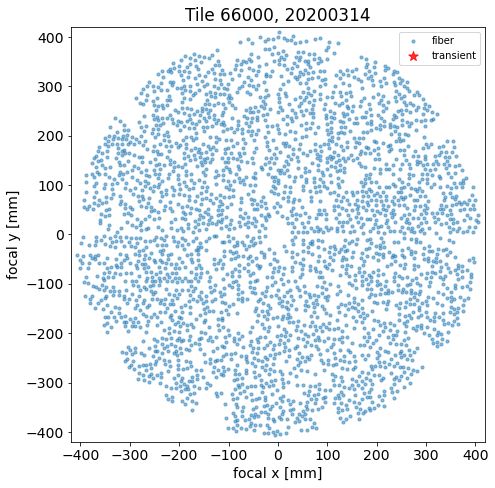

In [9]:
fig = compare_tile_to_tns(66000, 20200314, tnsdata)


##### Results: Tile 66000

Looks like there are no transients within tile 66000.

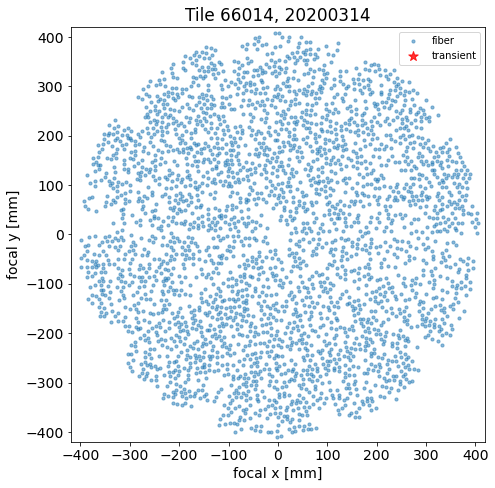

In [11]:
fig = compare_tile_to_tns(66014, 20200314, tnsdata)

##### Results: Tile 66014

Looks like there are no transients within tile 66014.

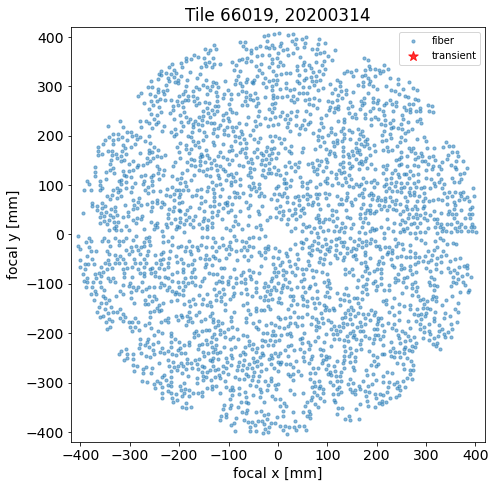

In [12]:
fig = compare_tile_to_tns(66019, 20200314, tnsdata)

##### Results: Tile 66019

Looks like there are no transients within tile 66019.

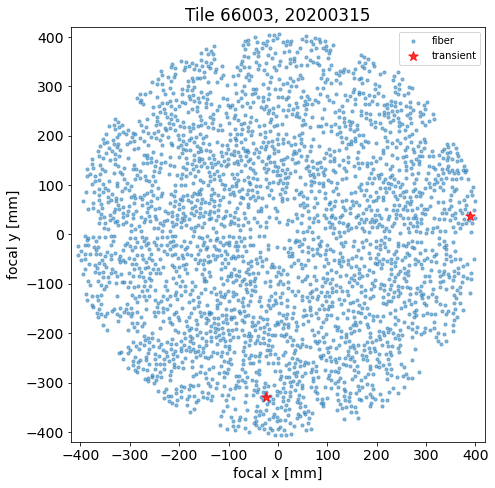

In [13]:
fig = compare_tile_to_tns(66003, 20200315, tnsdata)

##### Results: Tile 66003

Aha! There are two transients within tile 66003. Are any of them close to a fiber?

### Fiber-Transient Distance: Tile 66003

Grab all fiber positions from tile 66003.

In [14]:
coadds = sorted(glob('/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd*.fits'))
coadds

['/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-0-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-1-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-2-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-3-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-4-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-5-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-6-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-7-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-8-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/red

In [15]:
# This loop accumulates the fibermap position data and spectra from the coadd files.
allfmap = None
allwave = None
allflux = None
allivar = None
allmask = None

for coadd in coadds:
    spectra = read_spectra(coadd)
    
    # Accumulate only science targets allocated to BGS.
    isTGT = spectra.fibermap['OBJTYPE'] == 'TGT'
    isBGS = spectra.fibermap['CMX_TARGET'] & cmx_mask.mask(cmx_bgs_bits) != 0
    select = isTGT & isBGS
    
    if allfmap is None:
        allfmap = spectra.fibermap[select]
        allwave = spectra.wave['brz']
        allflux = spectra.flux['brz'][select]
        allivar = spectra.ivar['brz'][select]
        allmask = spectra.mask['brz'][select]
    else:
        allfmap = vstack([allfmap, spectra.fibermap[select]])
        allflux = np.vstack([allflux, spectra.flux['brz'][select]])
        allivar = np.vstack([allivar, spectra.ivar['brz'][select]])
        allmask = np.vstack([allmask, spectra.mask['brz'][select]])
        
spectra = Spectra(bands=['brz'],
                  wave={'brz' : allwave},
                  flux={'brz' : allflux},
                  ivar={'brz' : allivar},
                  mask={'brz' : allmask},
                  fibermap=allfmap)

In [16]:
print('{} targets selected'.format(len(spectra.fibermap)))

3026 targets selected


In [17]:
spectra.fibermap

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,MEAN_DELTA_X,MEAN_DELTA_Y,FIBER_RA,FIBER_DEC,COADD_NUMEXP,RMS_DELTA_X,RMS_DELTA_Y,FIRST_FIBER,LAST_FIBER,NUM_FIBER
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int16,int32,float64,int32,int64,int16,int32,bytes8,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,bytes1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int64,int64,int64
35191325326313329,0,520,520,471,0,179.49583074149854,57.253962640764634,0.0,0.0,0.0,0.0,0.0,5400.0,256,1,TGT,16.304935,-405.97717,0,10000,0.8022566338464723,65535,100,8001,609205,1793p572,1905,EXP,70740680000.0,64271438000.0,0.041671906,3.0611055,6.622557,11.148005,267.42862,75.09263,27.758736,0.88394773,0.92026335,0.95458394,4.689392e-05,3.905983e-05,0.00014099076,0.0061399224,0.0034771203,0.005564648,0.9971262,0.99869406,0.99789166,3,3,3,612.9182,261.357,103.19056,481.5059,171.02696,56.233593,17.009434,10.023304,85.761955,593.062,3.7634795,0.76996523,0.0014096936,1.8078397e-05,0.9929627,0.9956723,0.9990754,0.9996508,0,0,0,1.0056498,2.1756759,3.6623986,1.0056498,2.1756759,3.6623986,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0159984,0.05336821,0.16561714,4381.6914,2950.1543,5428.3906,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,True,0.0,0.0,N,256,2100,1,6005,0.0,0.0,0.0,0.0,0,0,0,3,16.379,-405.751,0.0023333333333333335,-0.002,0.0,0.0,3,0.00443471156521669,0.00496655480858378,471,471,1
35191325326313441,0,521,521,459,0,179.41698568279432,57.26205645603048,0.0,0.0,0.0,0.0,0.0,5400.0,72057594037928192,1,TGT,27.111708,-403.76944,0,10000,0.5984985916903893,65535,100,8001,609205,1793p572,2017,EXP,52842200000.0,38518907000.0,0.0

#### Compute Fiber-Transient Distance

Compare the fiber RA, DEC to the angular positions of transient coordinates.

In [18]:
tilecoords = SkyCoord(spectra.fibermap['TARGET_RA'],
                      spectra.fibermap['TARGET_DEC'], unit=('degree', 'degree'), frame='icrs')

# This function computes the angular distances of the tile fibers from the TNS transients.
# The idx array contains the indices of the TNS transients closest to the tile fiber coordinates.
idx, sep2d, dist3d = match_coordinates_sky(tilecoords, tnscoords)

#### Get the TNS objects inside the Tile Field of View

This next step is a bit tricky. We have to select the indices of the transients near the fibers in this tile.

We're actually going to:
1. Choose all transients within 0.5 degrees of any fiber in the focal plane for this tile.
2. Apply the `unique` function from numpy to get the coordinates in the TNS database.

In [19]:
j = np.unique(idx[sep2d < 0.5*u.degree])
j

array([1104, 1913])

#### Matching TNS Data:

These are the alerts close to fiber positions in the focal plane for tile 66003 on March 15, 2020.

One was discovered 8 weeks before the observation; the other 3.5 weeks before.

In [20]:
tnsdata[j]

ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s
int64,str10,str12,str12,str17,float64,str36,float64,str50,str45,str17,str45,str29,str114,str32,int64,int64,int64,float64,str12,str23,str18,int64,str56
55278,AT 2020ebq,11:59:20.720,+57:30:44.23,--,--,--,--,"SGLF, ZTF, Pan-STARRS1","ZTF, Pan-STARRS1",--,Pan-STARRS1; ZTF,ZTF20aasbfhx,"P48 - ZTF-Cam, PS1 - GPC1",--,1,1,--,20.506,r-ZTF,2020-02-27 10:55:21.000,Perez-Fournon,--,--
56289,AT 2020exy,11:46:43.925,+58:56:41.06,--,--,--,--,"ATLAS, Pan-STARRS1","ATLAS, Pan-STARRS1",--,ATLAS; Pan-STARRS1,ATLAS20iwe,"ATLAS1 - ACAM1, PS1 - GPC1",--,1,1,--,19.254,cyan-ATLAS,2020-03-24 10:45:07.200,ATLAS_Bot1,--,--


#### Find Matching Fibers

Did any of the transients happen to be caught by a fiber?

The fiber diameters are less than 1 arcsecond, so let's list all distances less than 1 arcsecond:

In [21]:
sep2d[sep2d < 1*u.arcsec]

<Angle [] deg>

There are no matches, so list all distances less than 1 arcminute.

In [22]:
sep2d[sep2d < 1*u.arcmin]

<Angle [0.00334242, 0.0160252 ] deg>

We have a couple of matches, but they're too far from any fiber to have been observed.
- The first match is 12 arcseconds away from the nearest fiber. Too far :(
- The second match is 57 arcseconds away from the nearest fiber. Much too far!

Still, we can look at the spectra of the best matched fibers to see what they look like.

In [23]:
spectra.fibermap[sep2d < 1*u.arcmin]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,MEAN_DELTA_X,MEAN_DELTA_Y,FIBER_RA,FIBER_DEC,COADD_NUMEXP,RMS_DELTA_X,RMS_DELTA_Y,FIRST_FIBER,LAST_FIBER,NUM_FIBER
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int16,int32,float64,int32,int64,int16,int32,bytes8,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,bytes1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int64,int64,int64
35191328602065210,0,360,360,190,0,179.83925765595478,57.51523650618314,0.0,0.0,0.0,0.0,0.0,5400.0,256,1,TGT,-30.222502,-335.34116,0,10000,0.5605552129045918,65535,100,8001,609986,1797p575,2362,DEV,420456300000.0,368596000000.0,0.020832332,3.5840735,11.4110365,22.099768,309.30612,85.7398,24.74298,0.940195,0.95931053,0.97703207,0.048125103,0.04929687,0.008736086,0.021234766,0.0028461823,0.16582403,0.7533383,0.60207665,0.7935408,3,3,2,558.107,256.49594,61.83891,442.83752,169.00055,35.773903,25.878523,19.554472,-20.98122,504.11163,3.895876,0.770944,0.0017126366,2.161623e-05,0.99647576,0.9978342,0.9995377,0.9998254,0,0,0,1.8125732,5.7709026,11.176514,1.8227825,5.7877455,11.200301,0,0,0,1.0,1.0,0.59580785,0.119742304,0.3617294,12581.096,6736.6914,7313.6187,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,True,0.0,0.0,N,256,2100,1,6005,0.0,0.0,0.0,0.0,0,0,0,3,-30.156,-335.164,0.0019999999999999996,-0.0003333333333333333,0.0,0.0,3,0.00648074069840786,0.0033166247903553994,190,190,1
35191347736478746,3,397,3397,1624,0,176.71399250904784,58.945982178978376,0.0,0.0,0.0,0.0,0.0,5400.0,256,1,TGT,377.4907,31.34506,0,10000,0.7199868412501728,65535,100,8001,614548,1768p590,1050,REX,110707270000.0,108025170000.0,0.0

Let's plot the fluxes of the fibers just to see what they look like.

In [24]:
i, j = np.argwhere(sep2d < 1*u.arcmin).flatten()

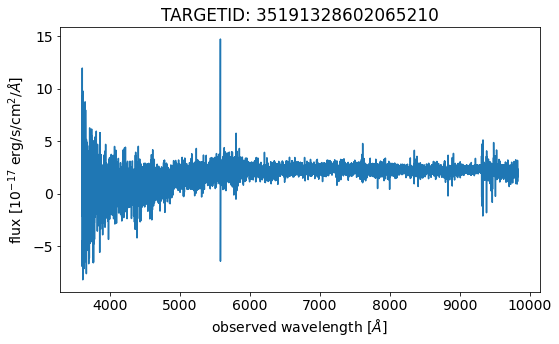

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)
ax.plot(spectra.wave['brz'], spectra.flux['brz'][i])
ax.set(title='TARGETID: {}'.format(spectra.fibermap[i]['TARGETID']),
       xlabel=r'observed wavelength [$\AA$]',
       ylabel=r'flux [$10^{-17}$ erg/s/cm$^2$/$\AA$]');

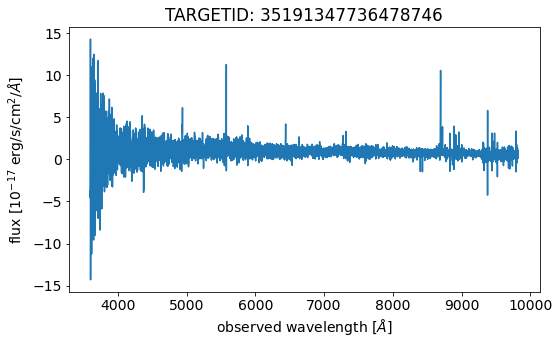

In [26]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)
ax.plot(spectra.wave['brz'], spectra.flux['brz'][j])
ax.set(title='TARGETID: {}'.format(spectra.fibermap[j]['TARGETID']),
       xlabel=r'observed wavelength [$\AA$]',
       ylabel=r'flux [$10^{-17}$ erg/s/cm$^2$/$\AA$]');

Both of these look like ordinary galaxies.